In [1]:
# 1. Install Dependencies and Setup
%pip install tensorflow tensorflow-gpu opencv-python matplotlib
%pip list

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: none)
ERROR: No matching distribution found for tensorflow-gpu

[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip



Package                      Version
---------------------------- -----------
absl-py                      1.4.0
asttokens                    2.2.1
astunparse                   1.6.3
autopep8                     2.0.0
backcall                     0.2.0
beautifulsoup4               4.11.1
blinker                      1.6.2
bs4                          0.0.1
cachetools                   5.3.0
certifi                      2022.12.7
cffi                         1.15.1
charset-normalizer           3.0.1
click                        8.1.3
colorama                     0.4.6
comm                         0.1.3
confusion-matrix             0.1
contourpy                    1.0.7
cycler                       0.11.0
dabl                         0.2.5
debugpy                      1.6.7
decorator                    5.1.1
dill                         0.3.6
dm-tree                      0.1.8
etils                        1.0.0
executing                    1.2.0
filelock                     3.12.0
Flask


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


C:\Users\ADEBOSS\AppData\Local\Temp\ipykernel_4332\2228248080.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')


[]

In [4]:
# 2. Remove dodgy images
import cv2
import imghdr

data_dir = 'dataset'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']
allowed_classes =['actinic keratosis','animal','basal cell carconima', 'melanoma','nevus','normal skin','pigmented benign keretosis','plants', 'squamous cell carcinoma','vascular lesion']

for image_class in os.listdir(data_dir):
    if image_class not in allowed_classes:
        continue 
    
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

Found 3602 files belonging to 10 classes.
Using 2882 files for training.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

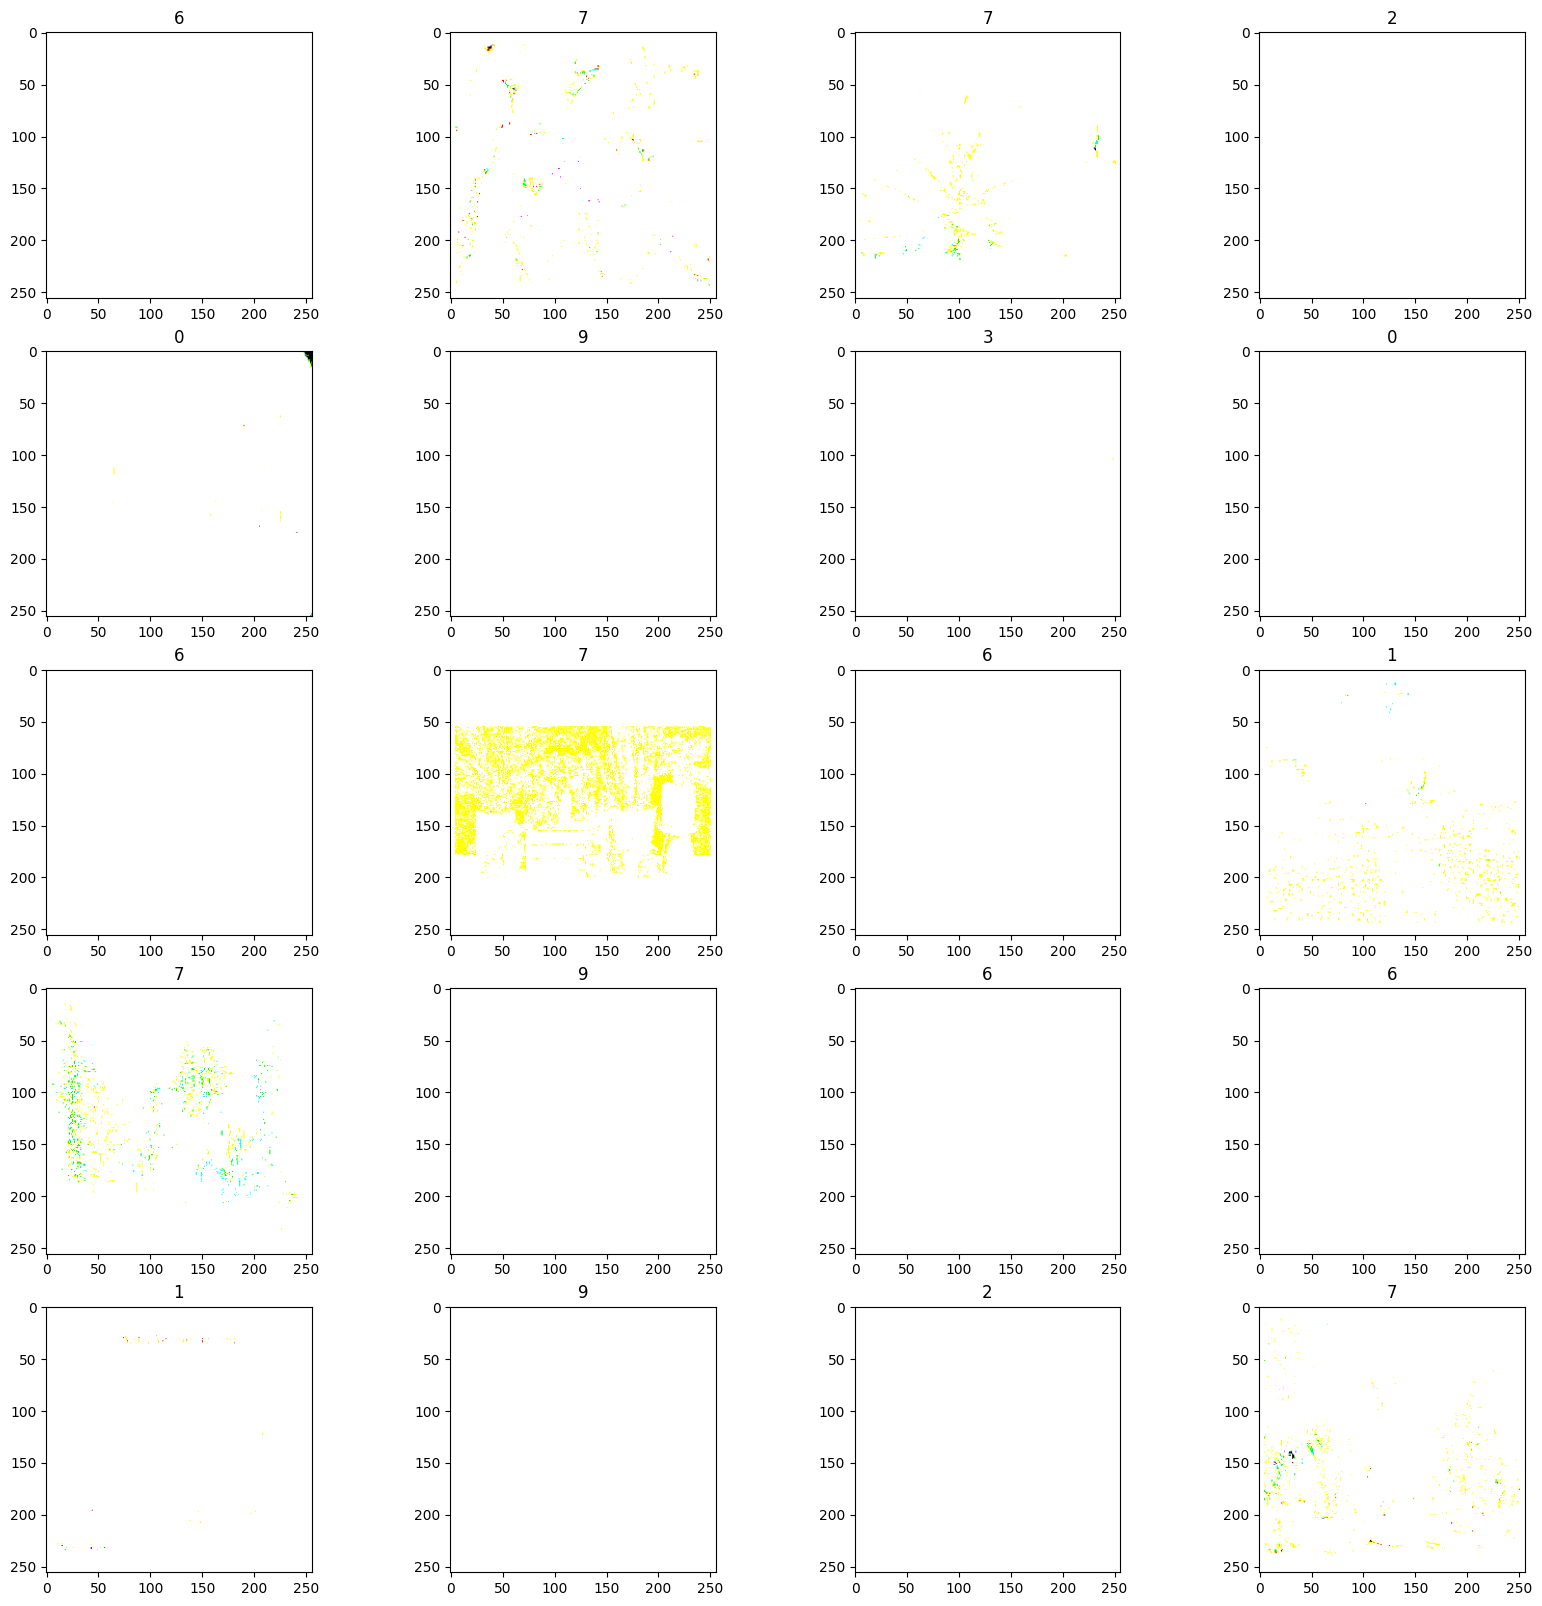

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom


# Load Data with Data Augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),       # Randomly flip images horizontally
    RandomRotation(0.2),            # Randomly rotate images by a maximum of 20%
    RandomZoom(0.2)                 # Randomly zoom images by a maximum of 20%
])

data = tf.keras.utils.image_dataset_from_directory(
    'dataset', 
    labels='inferred', 
    label_mode='int', 
    validation_split=0.2,           # Use 20% of the data for validation
    subset='training',              # Specify training subset without data augmentation
    seed=123,                       # Set a random seed for reproducibility
    image_size=(256, 256),          # Set the desired image size without data augmentation
    batch_size=32                   # Set the batch size without data augmentation
)


# Increase dataset size using data augmentation
def generator():
    for batch in data:
        # Convert the original images to float32 before applying data augmentation
        original_images = tf.image.convert_image_dtype(batch[0], tf.float32)
        for i in range(5):  # Augment each batch 5 times
            augmented_images = data_augmentation(original_images, training=True)  # Apply data augmentation
            # Keep the original labels for the augmented images
            yield augmented_images, batch[1]

augmented_data = tf.data.Dataset.from_generator(generator, output_signature=(tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32), tf.TensorSpec(shape=(None,), dtype=tf.int32)))

print("New size of the dataset after data augmentation:", len(list(augmented_data.as_numpy_iterator())))



data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20, 20))
for row in range(5):
    for col in range(4):
        idx = row * 4 + col
        img = batch[0][idx]
        label = batch[1][idx]
        ax[row, col].imshow(img)
        ax[row, col].title.set_text(label)
plt.show()


In [ ]:
# 4. Scale Data
data = data.map(lambda x, y: (x / 255, y))
data.as_numpy_iterator().next()


(array([[[[0.7983149 , 0.654565  , 0.701236  ],
          [0.7970282 , 0.6500984 , 0.7042126 ],
          [0.8033878 , 0.6596967 , 0.703215  ],
          ...,
          [0.85078984, 0.7160889 , 0.7880426 ],
          [0.8480931 , 0.72632575, 0.78982055],
          [0.83689255, 0.7082055 , 0.75773376]],
 
         [[0.79305327, 0.6447541 , 0.6965236 ],
          [0.7926846 , 0.6547349 , 0.68613374],
          [0.79748774, 0.6488535 , 0.6946167 ],
          ...,
          [0.8406556 , 0.71124387, 0.7785975 ],
          [0.83488053, 0.71275896, 0.7705966 ],
          [0.8397073 , 0.70459557, 0.7696538 ]],
 
         [[0.79750735, 0.6549084 , 0.6919577 ],
          [0.8030879 , 0.6550051 , 0.7063314 ],
          [0.80521625, 0.6685525 , 0.70959115],
          ...,
          [0.8376668 , 0.7069944 , 0.77868557],
          [0.8347838 , 0.6954133 , 0.7500919 ],
          [0.8373336 , 0.69988173, 0.74902844]],
 
         ...,
 
         [[0.7709449 , 0.6116903 , 0.6403471 ],
          [0.77717

In [ ]:
# 5. Split Data
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)
train_size, val_size, test_size

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [ ]:
# 6. Build Deep Learning Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Add dropout layer to reduce overfitting
model.add(Dense(10, activation='softmax'))  # 10 output classes

optimizer = Adam(learning_rate=0.001)  # Set learning rate for optimizer

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

In [ ]:
# 7. Train
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=30, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/30
63/63 [==============================] - 560s 8s/step - loss: 1.9472 - accuracy: 0.3056 - val_loss: 1.4962 - val_accuracy: 0.4705
Epoch 2/30
63/63 [==============================] - 513s 8s/step - loss: 1.4838 - accuracy: 0.4479 - val_loss: 1.3026 - val_accuracy: 0.4705
Epoch 3/30
63/63 [==============================] - 483s 8s/step - loss: 1.3033 - accuracy: 0.5149 - val_loss: 1.2350 - val_accuracy: 0.5382
Epoch 4/30
63/63 [==============================] - 495s 8s/step - loss: 1.1769 - accuracy: 0.5605 - val_loss: 1.0801 - val_accuracy: 0.5573
Epoch 5/30
63/63 [==============================] - 466s 7s/step - loss: 1.0708 - accuracy: 0.6096 - val_loss: 1.1360 - val_accuracy: 0.6146
Epoch 6/30
63/63 [==============================] - 422s 7s/step - loss: 1.0156 - accuracy: 0.6310 - val_loss: 1.0507 - val_accuracy: 0.5851
Epoch 7/30
63/63 [==============================] - 467s 7s/step - loss: 0.9492 - accuracy: 0.6587 - val_loss: 1.0733 - val_accuracy: 0.5816
Epoch 8/30
63

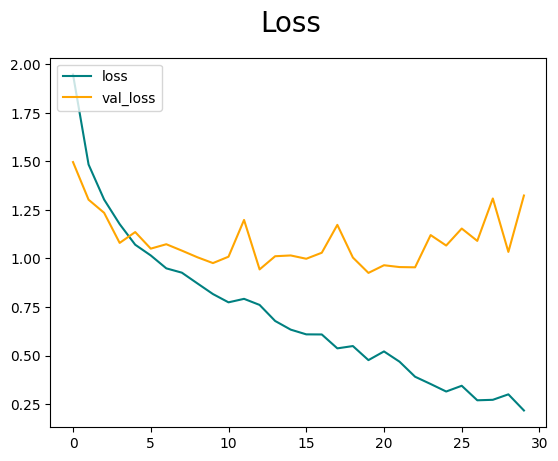

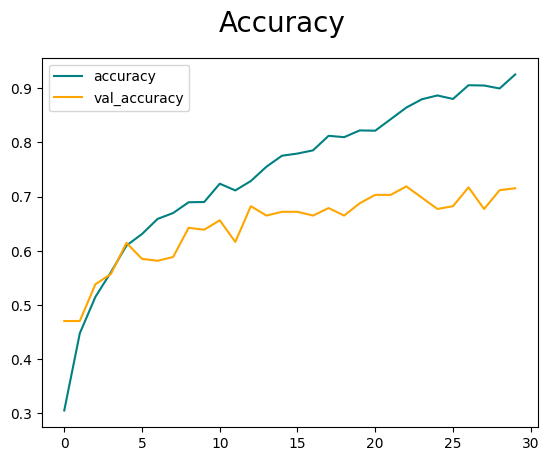

In [ ]:
# 8. Plot Performance
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
# 9. Evaluate
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    yhat_classes = np.argmax(yhat, axis=-1)  # Get the predicted class indices
    
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)
print(pre.result(), re.result(), acc.result())


1/1 [==============================] - 2s 2s/step
tf.Tensor(0.975, shape=(), dtype=float32) tf.Tensor(0.975, shape=(), dtype=float32) tf.Tensor(0.13194445, shape=(), dtype=float32)


In [ ]:
# 10. Test
import cv2

In [ ]:

img = cv2.imread('dataset/animal/0007.jpg')
plt.imshow(img)
plt.show()

resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = model.predict(np.expand_dims(resize / 255, 0))
predicted_class_index = np.argmax(yhat)  # Get the index of the highest probability class

classes =['actinic keratosis','animal','basal cell carconima', 'melanoma','nevus','normal skin','pigmented benign keretosis','plants', 'squamous cell carcinoma','vascular lesion']
print(f'score : {[yhat]}')
if predicted_class_index < len(classes):
    predicted_class = classes[predicted_class_index]
    print(f'Predicted class is a {predicted_class}')
else:
    print('Error: Image does not belong to skin cancer class.')

NameError: name 'cv2' is not defined

In [ ]:
# 11. Save the Model
from tensorflow.keras.models import load_model

model.save(os.path.join('models', 'imageclassifiers.h5'))
new_model = load_model('models/imageclassifiers.h5')
new_model.predict(np.expand_dims(resize / 255, 0))


1/1 [==============================] - 1s 775ms/step


array([[6.4236566e-10, 9.9932456e-01, 2.5031823e-06, 1.8505618e-06,
        2.7745749e-08, 1.7076048e-06, 5.5211302e-09, 6.6940545e-04,
        9.8135530e-13, 4.9543175e-11]], dtype=float32)